# Clustering data in sphere coordinates
While playing around with DBScan clustering I noticed that after 30 meters it's difficult to detect objects. This is logical, as the pointcloud is not actually uniformly distributed. Close to the LiDAR points are close together, as the angle between points is uniform. I wanted to test how well clustering would work if we would instead run it in a  [spherical coordinate space](https://en.wikipedia.org/wiki/Spherical_coordinate_system). 

I tested it on a run if KITTI data, you can download it as well to run this Jupyter Notebook

In [ ]:
# Download and extract data... 
#!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0018/2011_09_26_drive_0018_sync.zip
#!unzip 2011_09_26_drive_0018_sync.zip

### Dependencies: 
The code relies heavily on scikit-learn, as this is necessary for both clustering and the most basic ground-plane removal algorithm.. 


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import math
import os
from sklearn.cluster import DBSCAN
import sklearn

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
def remove_ground_plane(points, res_tres=0.25, min_dist_to_plane=0.4):
    """Simple ground plane removal algorithm that fits a plane through a pointcloud, and 
    removes everything in a plane where it can remove the most points... """
    ground_ransac = sklearn.linear_model.RANSACRegressor(sklearn.linear_model.LinearRegression(), residual_threshold=res_tres)
    XY = points[:, :2]
    height = points[:, 2]

    ground_ransac.fit(XY, height)

    predicted_height = ground_ransac.predict(XY)
    d_to_plane = np.abs(height - predicted_height)
    road_mask = d_to_plane < min_dist_to_plane
    not_road_mask = np.logical_not(road_mask)
    return points[not_road_mask]

def load_points_without_ground(filename):
    """ Loads points, and removes the ground plane immediately"""
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    points = points[:,:3] # Remove the intensity of the points
    points = remove_ground_plane(points)
    return points

foldername = "2011_09_26_drive_0018_sync"
basepath = os.path.join("2011_09_26", foldername, "velodyne_points/data/")

### Projecting. 
The Wikipedia article on spherical projections is pretty good. For the function implementation I copy-pasted someone elses [code](https://github.com/numpy/numpy/issues/5228). Note that there might be some improvements, either with the projection or with the calibration of the KITTI data. When looking at the azimuth-polar-visualisation I expect all lines to be straight, but this seems to be not the case. 

In [6]:
# Functions taken from here: https://github.com/numpy/numpy/issues/5228
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z

In [7]:
def dbscan(points, eps):
    """Cluster the points, and return the labels"""
    db = DBSCAN(eps=eps, min_samples=14).fit(points)
    labels = db.labels_    
    return labels

def plot_data(points, labels, filename, axis=None):
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    import random 
    random.shuffle(colors)
    plt.figure(figsize=(30,30))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = points[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor=tuple(col), markersize=0.5)
    if axis:
        plt.axis(axis) 
    
    
    foldername = Path(os.path.dirname(filename))
    foldername.mkdir(parents=True, exist_ok=True)

    plt.savefig(filename)
    plt.close()

### Running the program
With everything defined, I go over a whole run and visualise a bunch of projections. 

Note that we are now in an alternative space, where azimuth and elevation are in radians, but the distance is still in meters. This makes it difficult to cluster. I therefore scale the distance to points to be closter to the distance between points in radians, but this approach is far from perfect. 

0000000000.bin


SystemError: <built-in method write of _io.BufferedWriter object at 0x7fd077df1bf8> returned a result with an error set

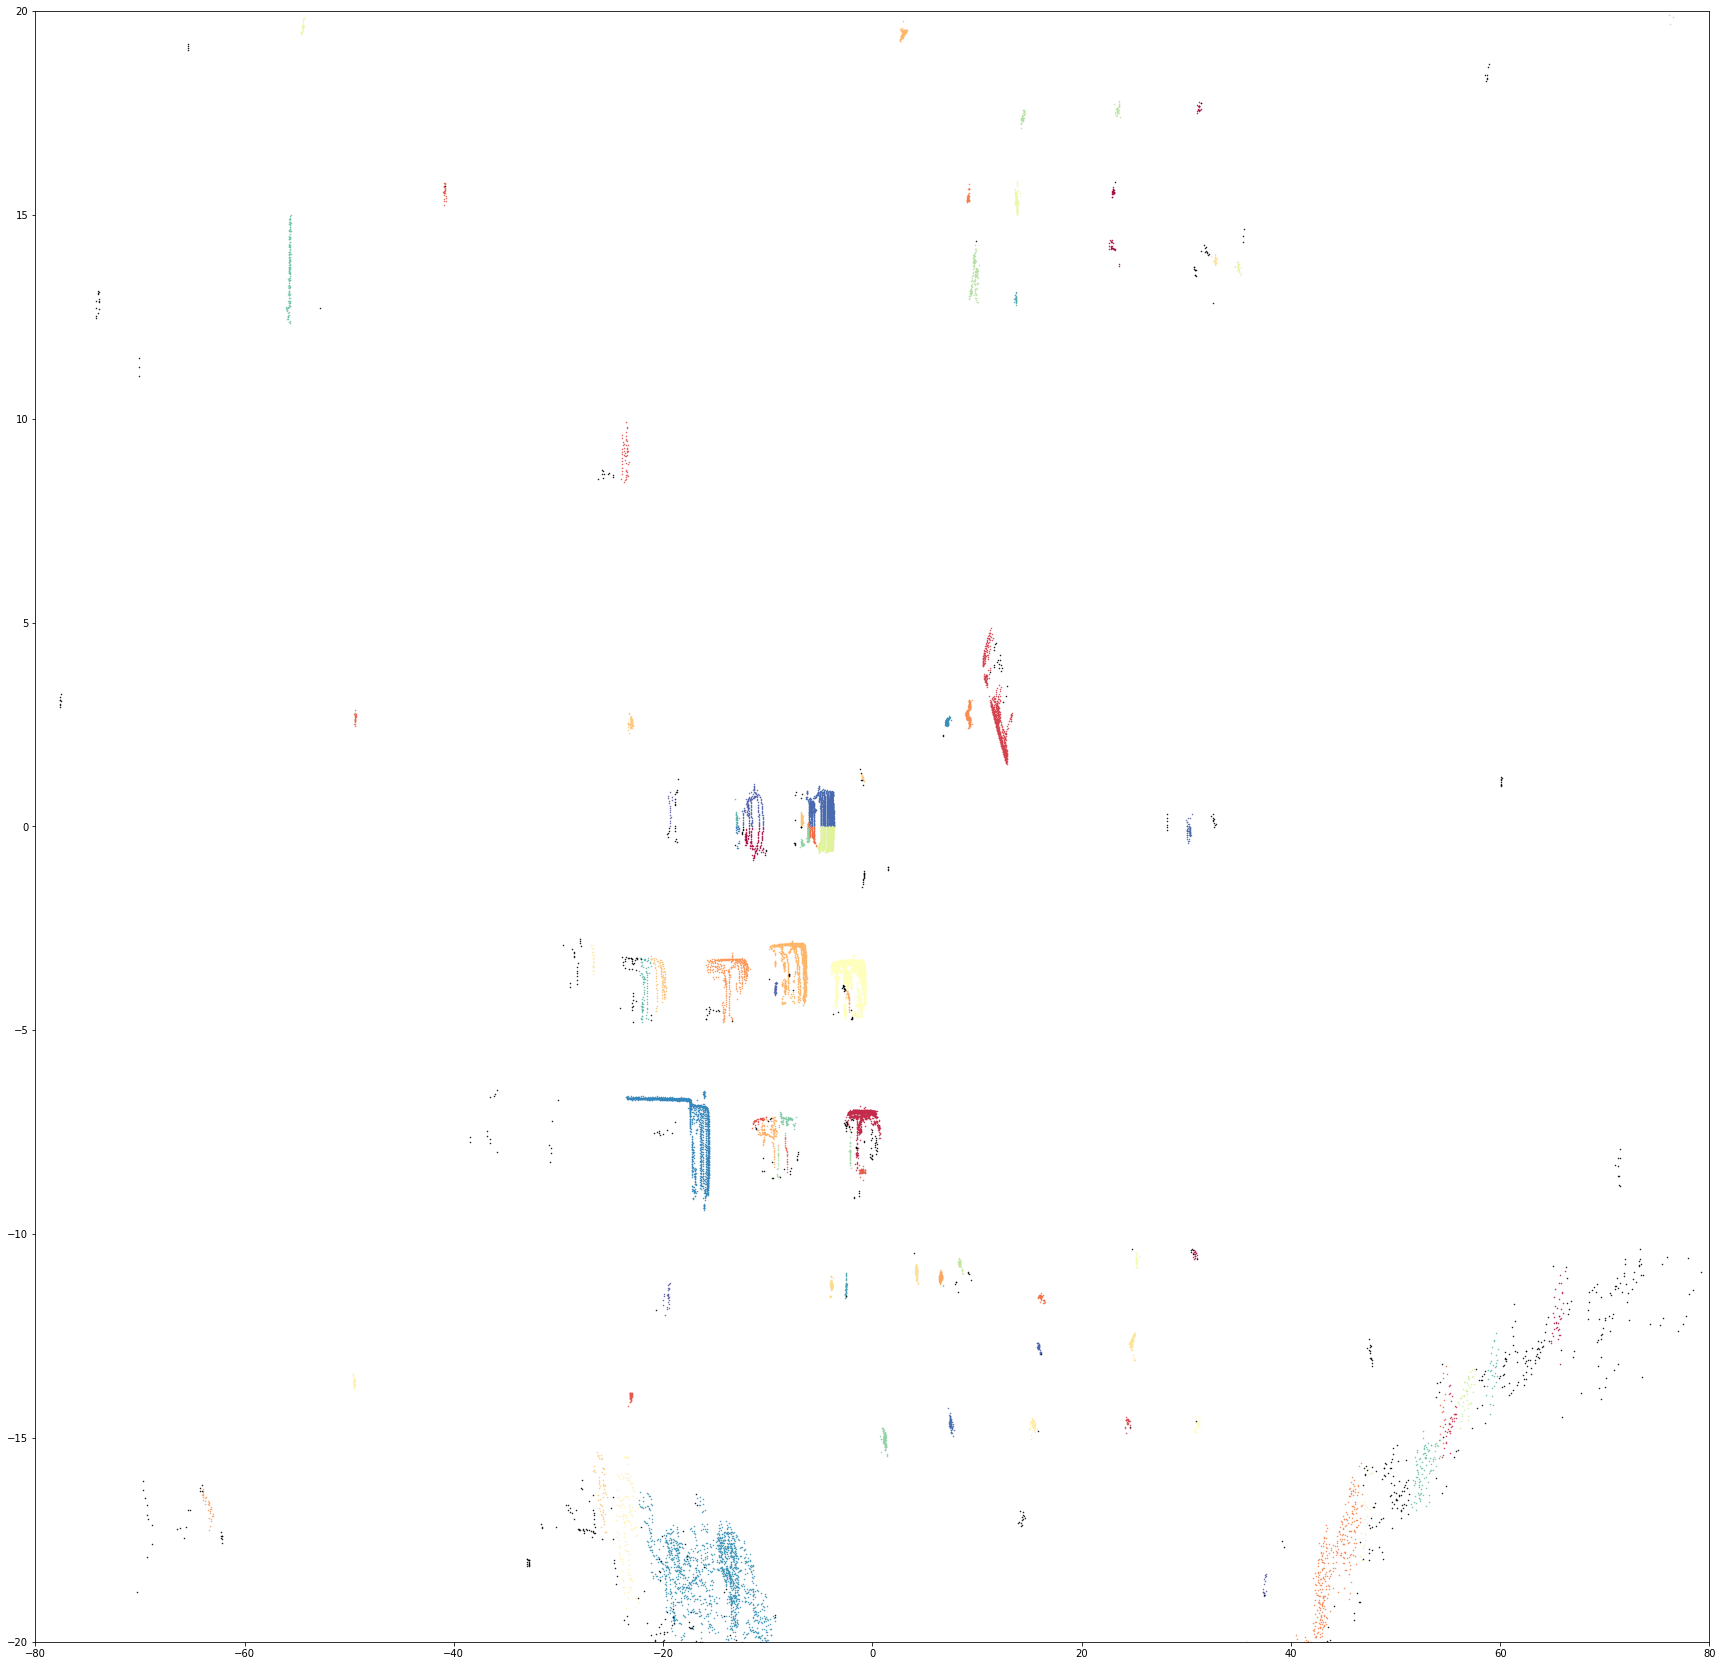

In [8]:

for filename in sorted(os.listdir(basepath)):
    print(filename)
    complete_path = os.path.join(basepath, filename)
    points = load_points_without_ground(complete_path)
    labels = dbscan(points, 0.3)
    plot_data(points, labels, os.path.join("out_images", foldername, "euclidian", filename+".png"), axis=[-80, 80, -20, 20])

    az, el, r = cart2sph(points[:,0], points[:,1], points[:,2])
    # Divide the distance to points by 10, to come closer to the angular distance space. 
    # Note that 10.0 is probably not mathematically correct, but hey, it's Sunday!
    r /= 10.0 
    cartesian = np.stack([az, el, r], axis=1)
    
    labels = dbscan(cartesian, 0.03) # Tweak this parameter, it is guessed by looking at some results... 
    plot_data(points, labels, os.path.join("out_images", foldername, "cartesian", filename+".png"), axis=[-80, 80, -20, 20])    
    
    # For debugging: output all coordinate spaces to see what is happening there. 
    cartesian = np.stack([az, el, r], axis=1)
    plot_data(cartesian, labels, os.path.join("out_images", foldername, "cartesian_repr_az_el", filename+".png"), axis='equal')    
    cartesian = np.stack([el, r, az], axis=1)
    plot_data(cartesian, labels, os.path.join("out_images", foldername, "cartesian_repr_r_el", filename+".png"), axis='equal')    
    cartesian = np.stack([az, r, el], axis=1)
    plot_data(cartesian, labels, os.path.join("out_images", foldername, "cartesian_repr_r_az", filename+".png"), axis='equal')    
    

In [9]:
from create_gif import gif_from_folder
import os
path = os.path.join("out_images", foldername, "cartesian") # on Mac: right click on a folder, hold down option, and click "copy as pathname"
gif_from_folder(path, ('.jpeg', '.png', '.gif'), 'cartesian.gif')


ValueError: Could not load "" 
Reason: "unrecognized data stream contents when reading image file"
Please see documentation at: http://pillow.readthedocs.org/en/latest/installation.html#external-libraries